In [4]:
!pip install torch==1.12.0 torchvision==0.13.0
!pip install d2l==1.0.0b0

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 MB 5.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 118.9 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip available: 22.3 -> 23.0.1
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.6/141.6 kB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 kB 60.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 123.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.6/155.6 kB 39.4 MB/s eta 0:00:00
  Created wheel for gym: filename=gym-0.21.0-py3-none-any.whl size=1616824 sha256=98626d827e118f61367fd0e12a2ec12b2a858cef1fffbcef47ccf8cf05524ce8
  Stored in directory: /home/ubu

In [6]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from d2l import torch as d2l
import numpy as np
import matplotlib.pyplot as plt

In [31]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(28*28, 256, bias=True),
            nn.Dropout(p=0.1),
            nn.ReLU(),
            nn.Linear(256, 10, bias=True),
            nn.Dropout(p=0.1),
            nn.ReLU(),
            nn.Softmax(dim=1)
        ) 

    def forward(self, images, labels):
        y = self.net(images)
        loss = F.cross_entropy(y, labels)
        return loss

    def predict(self, images):
        images = images.view(images.size(0), -1)
        outp = self.net(images)
        _, labels_pred = torch.max(outp, 1)
        return labels_pred


        

In [32]:
batch_size = 16
transform = transforms.Compose([
    transforms.ToTensor(), # convert images to tensors
    transforms.Normalize((0.1307,), (0.3081,)) # normalize the pixel values
])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Split the training dataset into training and validation sets
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [50000, 10000])

# Create data loaders for each dataset
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [33]:
def eval_acc(model, data_loader):
  
  with torch.no_grad():
    model.eval()
    
    total = 0
    correct = 0
    
    for (images, labels) in data_loader:
      images = images.cuda()
      labels = labels.cuda()
      
      labels_pred = model.predict(images)
      
      total += labels.shape[0]
      correct += (labels_pred == labels).sum().item()
    
    acc = 100 * correct / total
  
  return acc

In [38]:
torch.manual_seed(0)
model = MLP()
model = model.cuda()
import torch.optim as optim
num_epochs = 40
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Train Epoch:   0 	 Loss: 2.299557 	 Val Acc: 13.430000
Train Epoch:   1 	 Loss: 2.018574 	 Val Acc: 76.090000
Train Epoch:   2 	 Loss: 1.824770 	 Val Acc: 82.840000
Train Epoch:   3 	 Loss: 1.719157 	 Val Acc: 91.230000
Train Epoch:   4 	 Loss: 1.605226 	 Val Acc: 92.100000
Train Epoch:   5 	 Loss: 1.470396 	 Val Acc: 92.640000
Train Epoch:   6 	 Loss: 1.538249 	 Val Acc: 93.240000
Train Epoch:   7 	 Loss: 1.642801 	 Val Acc: 93.730000
Train Epoch:   8 	 Loss: 1.486793 	 Val Acc: 93.970000
Train Epoch:   9 	 Loss: 1.653192 	 Val Acc: 94.440000
Train Epoch:  10 	 Loss: 1.594103 	 Val Acc: 94.530000
Train Epoch:  11 	 Loss: 1.598754 	 Val Acc: 94.730000
Train Epoch:  12 	 Loss: 1.529273 	 Val Acc: 94.870000
Train Epoch:  13 	 Loss: 1.540626 	 Val Acc: 94.930000
Train Epoch:  14 	 Loss: 1.626694 	 Val Acc: 95.170000
Train Epoch:  15 	 Loss: 1.526172 	 Val Acc: 95.300000
Train Epoch:  16 	 Loss: 1.519329 	 Val Acc: 95.470000
Train Epoch:  17 	 Loss: 1.464004 	 Val Acc: 95.450000
Train Epoc

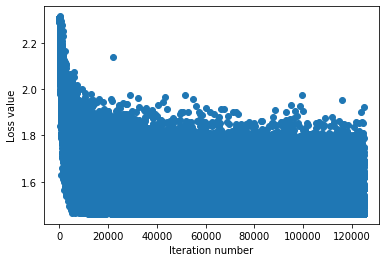

In [39]:
loss_history = []
for epoch in range(num_epochs):
  val_acc = eval_acc(model, val_loader)
  
  model.train()
  
  for batch, (images, labels) in enumerate(train_loader):
    images = images.view(images.size(0), -1)
    images = images.cuda()
    labels = labels.cuda()
    
    optimizer.zero_grad()
    loss = model(images, labels)
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
      loss_history.append(loss.item())
      if batch == 0:
        print('Train Epoch: {:3} \t Loss: {:F} \t Val Acc: {:F}'.format(
          epoch, loss.item(), val_acc))

with torch.no_grad():
  plt.plot(loss_history, 'o')
  plt.xlabel('Iteration number')
  plt.ylabel('Loss value')
  plt.show()

In [56]:
def display(images, titles=""):
  if type(images) is not list:
    images = [images]
    titles = [titles]
  num = len(images)
  assert len(titles) == num

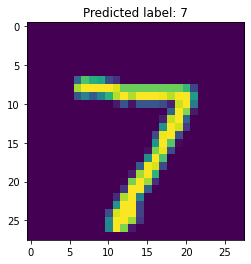

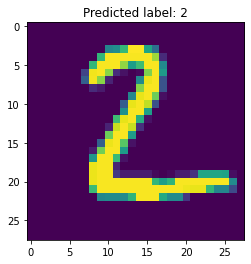

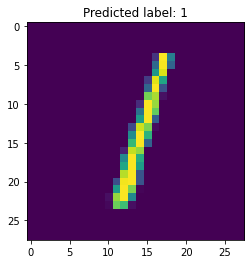

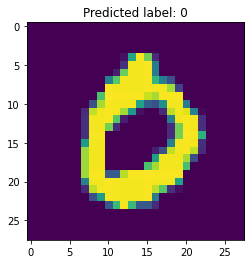

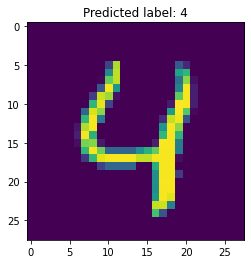

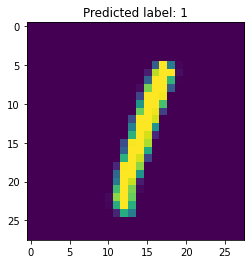

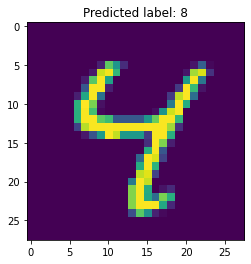

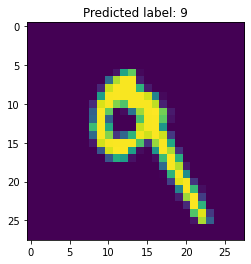

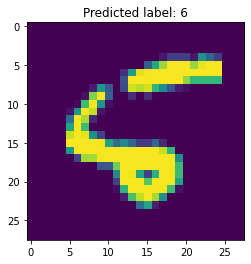

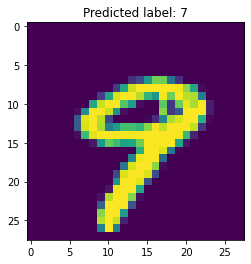

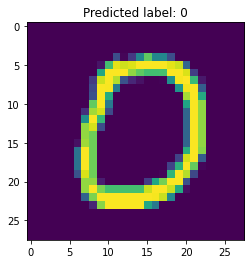

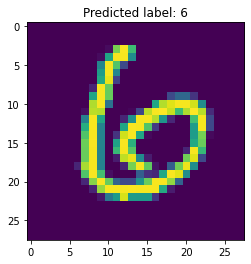

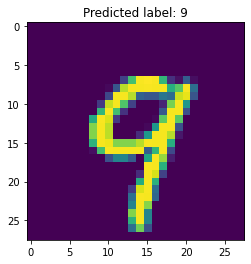

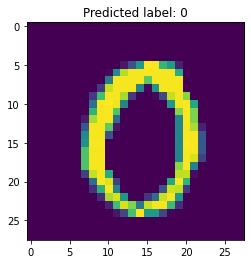

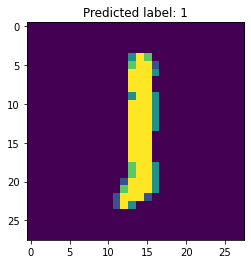

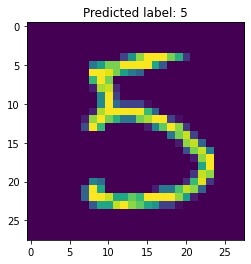

In [66]:
data, labels = next(iter(test_loader))
pred_labels = model.predict(data.cuda())
    
for i in range(data.shape[0]):
    img = data[i].cpu().numpy()
    img = img.transpose(1, 2, 0)
    plt.imshow(img)
    plt.title("Predicted label: {}".format(pred_labels[i]))
    plt.show()

In [67]:
print(eval_acc(model, test_loader))

97.41


In [69]:
print(eval_acc(model, train_loader))
print(eval_acc(model, val_loader))

98.416
96.92
